This Notebook analyses all the results for all the regions in the challenge

In [138]:
%cd '/home/urbanaq/cams_downscaling'

/home/urbanaq/cams_downscaling


In [139]:
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from cams_downscaling.utils import get_db_connection, read_config

In [140]:
config = read_config('/home/urbanaq/cams_downscaling/config')

In [141]:
def get_validation_data(version, date_ini, date_end):
    conn = get_db_connection()
    cursor = conn.cursor()
    
    cursor.execute(f"SELECT station, model_version, MQI, fraction, RMSE, beta, RMS_U, bias, CRMSE FROM validation WHERE model_version = {version} AND time_ini = '{date_ini}' AND time_end = '{date_end}' AND station != '90th'")
    validation = cursor.fetchall()
    cursor.close()
    conn.close()

    validation = pd.DataFrame(validation, columns=["station_id", "version", "MQI", "fraction", "RMSE", "beta", "RMS_U", "bias", "CRMSE"])

    validation.MQI = validation.MQI.astype(float)
    validation.fraction = validation.fraction.astype(float)
    validation.RMSE = validation.RMSE.astype(float)
    validation.beta = validation.beta.astype(float)
    validation.RMS_U = validation.RMS_U.astype(float)
    validation.bias = validation.bias.astype(float)
    validation.CRMSE = validation.CRMSE.astype(float)
    
    return validation

# 1. Iberia

In [142]:
countries = ["Spain", "Portugal"]
region = "iberia"

In [143]:
conn = get_db_connection()
cursor = conn.cursor()
cursor.execute("SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN %s", (countries,))
clusters = cursor.fetchall()
cursor.close()
conn.close()

clusters = pd.DataFrame(clusters, columns=["station_id", "cluster", "lat", "lon"])
clusters

,station_id,cluster,lat,lon
0,ES0041A,1013,43.2588,-2.9457
1,ES0110A,1014,43.3027,-2.9772
2,ES0118A,101,40.4217,-3.6822
3,ES0120A,101,40.4517,-3.6772
4,ES0124A,101,40.4400,-3.6392
...,...,...,...,...
178,PT03087,200,38.7050,-9.2103
179,PT03095,200,38.6586,-9.0669
180,PT03097,200,38.8022,-9.1822
181,PT03100,200,38.7481,-9.2025


## 1.1 Validate 2022

In [144]:
date_ini = "2022-01-01 00:00:00"
date_end = "2022-12-31 00:00:00"
cams_version_raw = -1000
model_versions = [1001, 1011, 1021, 1031, 1041, 1061, 1071, 1081, 1091, 1101]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [145]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

,station_id,version,MQI,fraction,RMSE,beta,RMS_U,bias,CRMSE,cluster,lat,lon
0,ES0041A,-1000,0.822,0.948,20.313,2.0,12.349,-16.017,12.492,1013,43.2588,-2.9457
1,ES0118A,-1000,0.588,0.990,15.858,2.0,13.489,-11.748,10.652,101,40.4217,-3.6822
2,ES0120A,-1000,0.619,0.992,16.398,2.0,13.254,-8.644,13.934,101,40.4517,-3.6772
3,ES0124A,-1000,0.432,0.716,11.267,2.0,13.027,-4.295,10.416,101,40.4400,-3.6392
4,ES0125A,-1000,0.667,0.988,19.104,2.0,14.317,-11.677,15.121,101,40.3469,-3.7050
...,...,...,...,...,...,...,...,...,...,...,...,...
1658,PT03087,1101,0.319,0.030,6.610,2.0,10.353,0.254,6.605,200,38.7050,-9.2103
1659,PT03095,1101,0.307,0.032,6.483,2.0,10.555,2.287,6.066,200,38.6586,-9.0669
1660,PT03097,1101,0.381,0.014,8.237,2.0,10.802,0.613,8.214,200,38.8022,-9.1822
1661,PT03100,1101,0.318,0.027,8.889,2.0,13.972,-3.058,8.346,200,38.7481,-9.2025


In [146]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

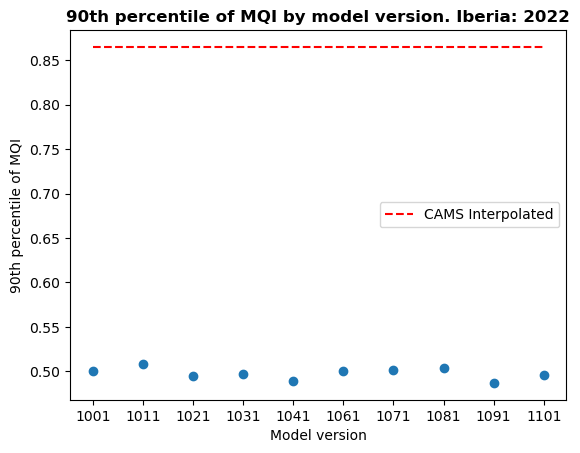

In [147]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots()
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()


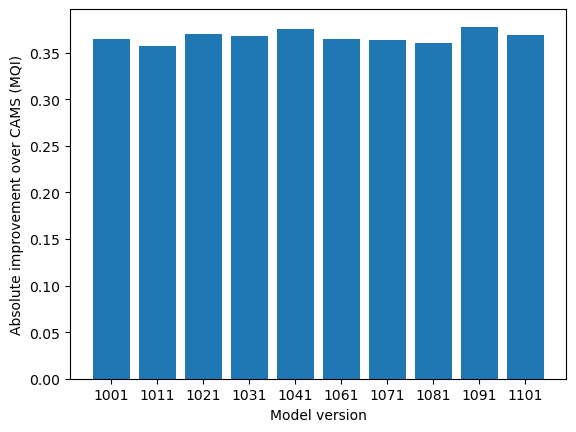

In [148]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()


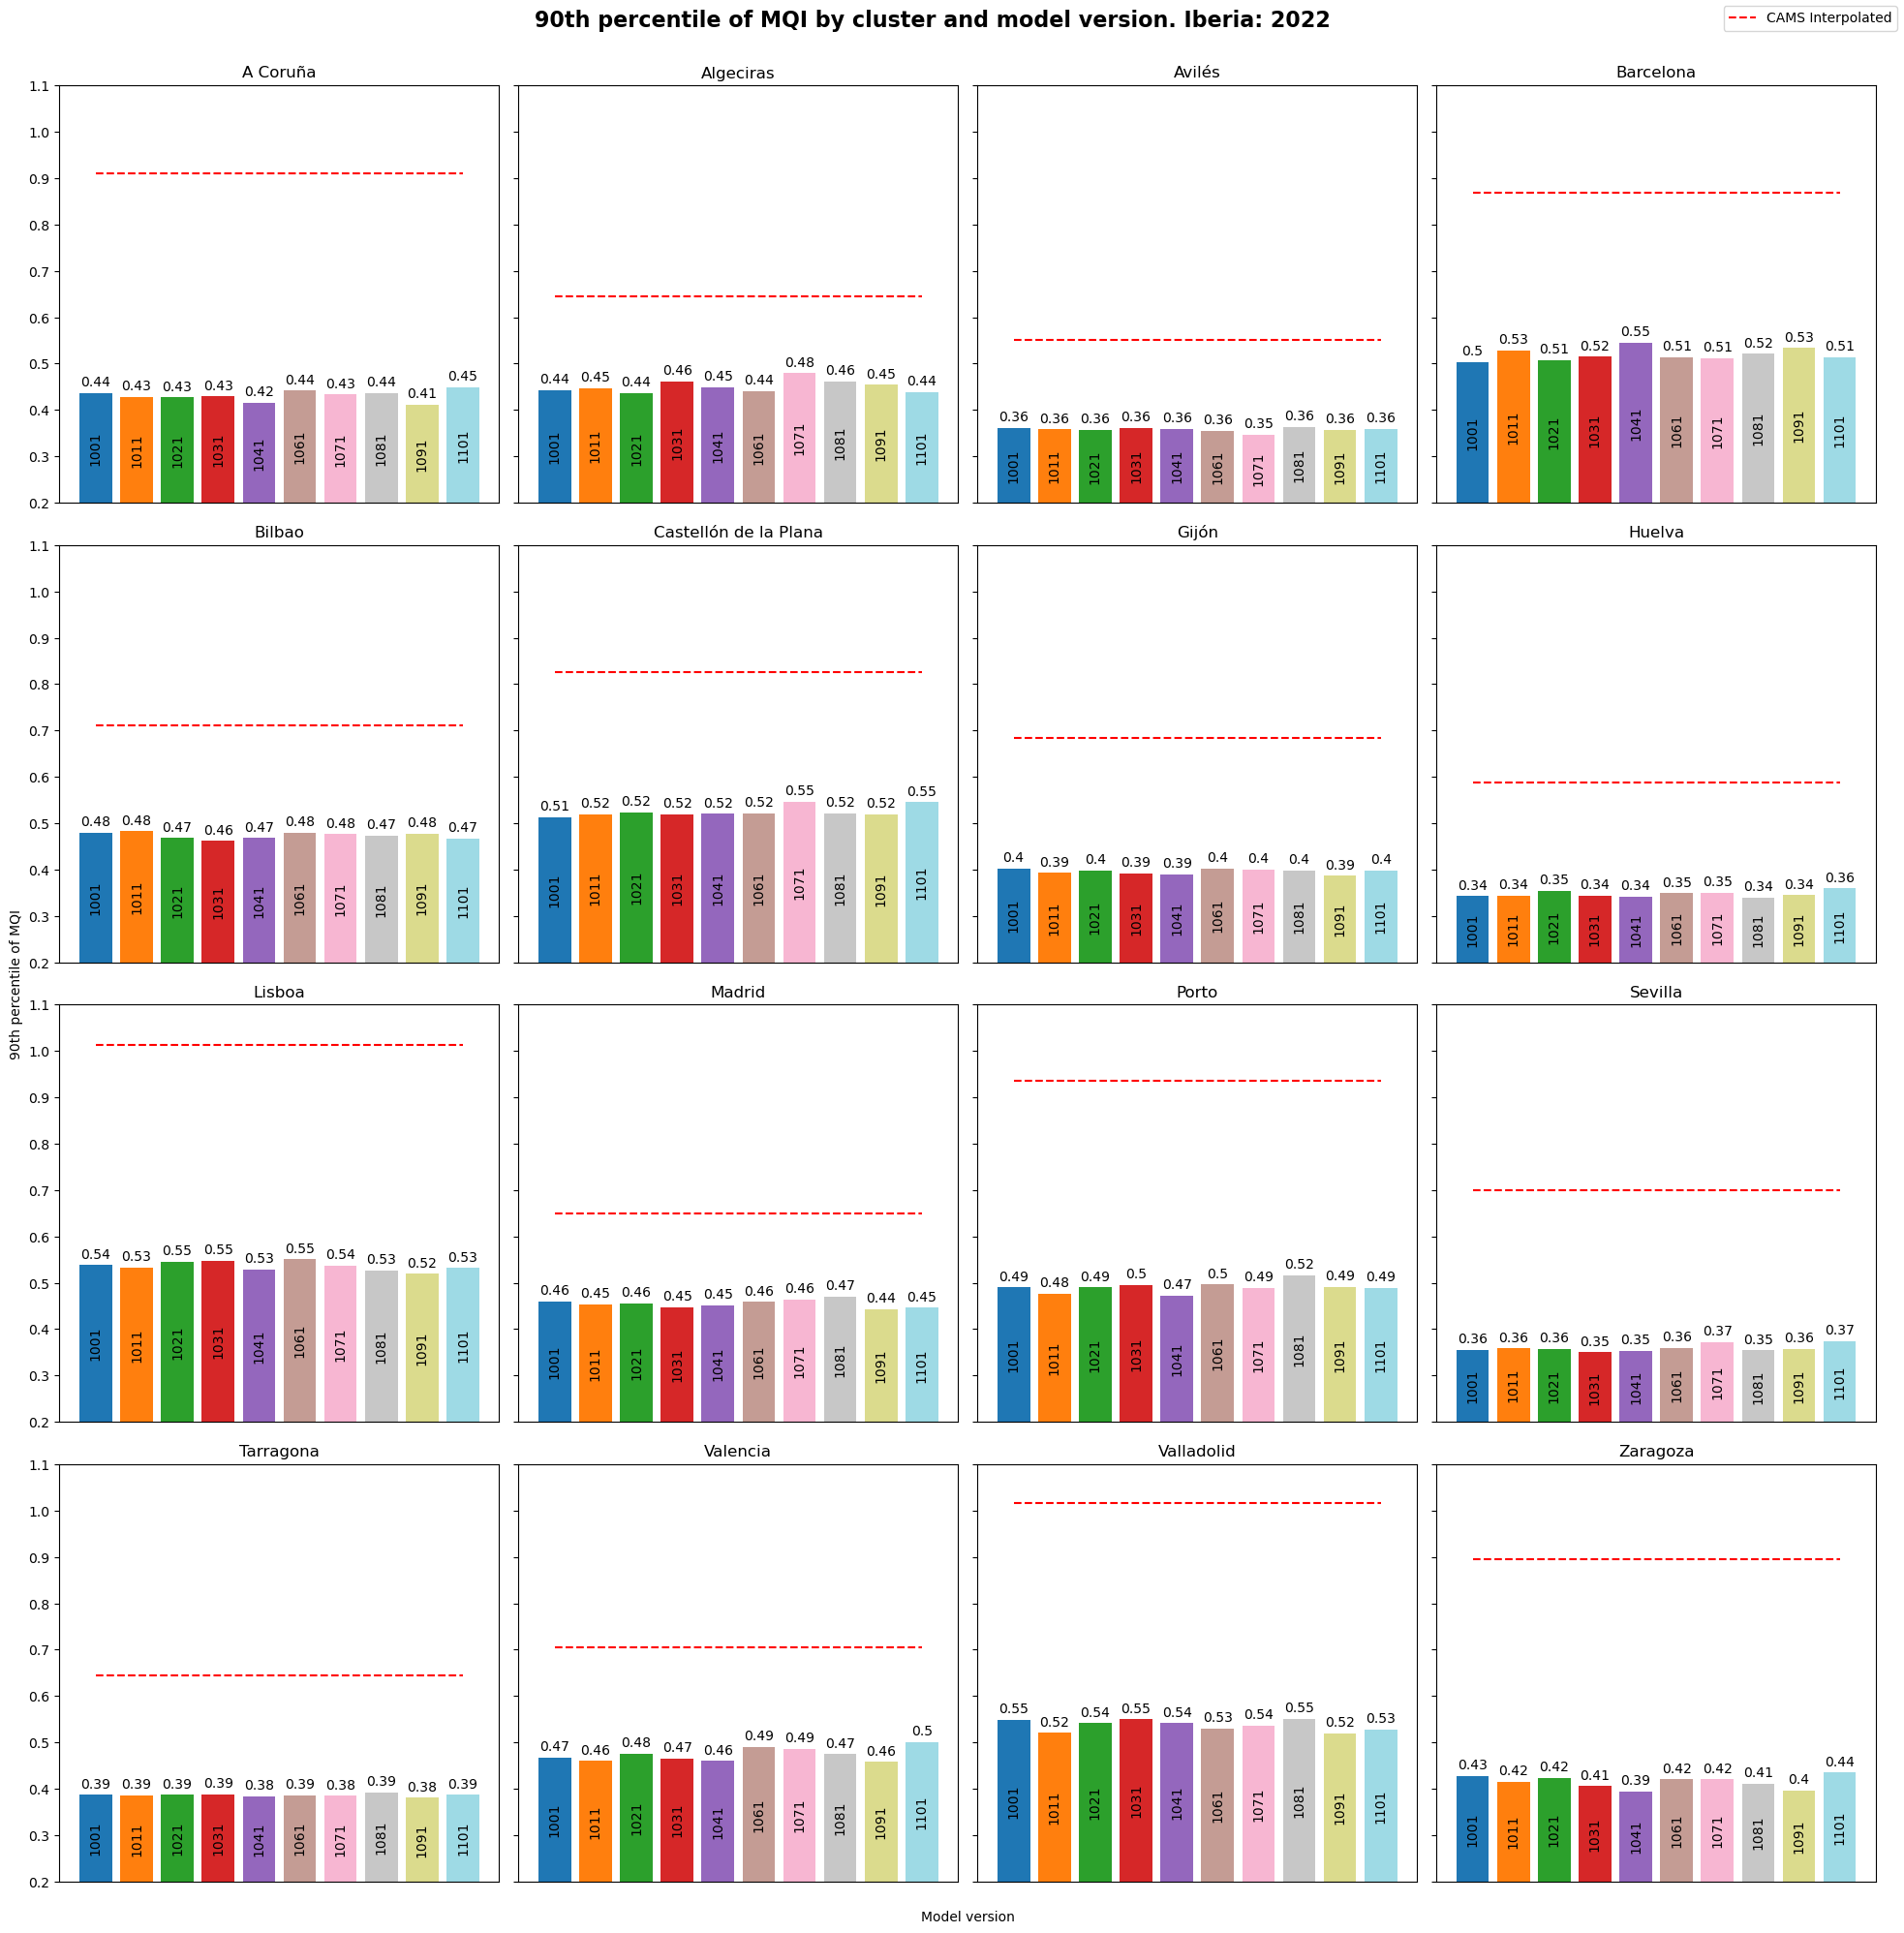

In [149]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, len(df_renamed.index) // 4, figsize=(20, 20), sharex=True, sharey=True)

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i // 4, i % 4].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i // 4, i % 4].bar_label(rects, labels, padding=3)
    ax[i // 4, i % 4].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i // 4, i % 4].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i // 4, i % 4].set_title(cluster)
    ax[i // 4, i % 4].set_ylim(0.2, 1.1)

    
    ax[i // 4, i % 4].set_xticks([])
    ax[i // 4, i % 4].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i // 4, i % 4].set_yticks(np.arange(0.2, 1.15, 0.1))

    handles, labels = ax[i // 4, i % 4].get_legend_handles_labels()

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [150]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed


version,-1000,1001,1011,1021,1031,1041,1061,1071,1081,1091,1101
cluster,,,,,,,,,,,
Zaragoza,0.8960,0.4270,0.4155,0.4240,0.4055,0.3945,0.4200,0.4200,0.4115,0.3955,0.4350
Madrid,0.6500,0.4600,0.4530,0.4560,0.4470,0.4510,0.4590,0.4640,0.4700,0.4430,0.4460
Algeciras,0.6460,0.4432,0.4476,0.4370,0.4614,0.4486,0.4412,0.4792,0.4612,0.4544,0.4386
Huelva,0.5888,0.3424,0.3438,0.3538,0.3444,0.3410,0.3486,0.3504,0.3402,0.3450,0.3594
Sevilla,0.7000,0.3552,0.3588,0.3576,0.3498,0.3538,0.3596,0.3722,0.3540,0.3580,0.3736
Avilés,0.5502,0.3616,0.3580,0.3567,0.3611,0.3591,0.3553,0.3472,0.3634,0.3574,0.3588
Gijón,0.6844,0.4026,0.3930,0.3978,0.3912,0.3902,0.4026,0.4000,0.3984,0.3862,0.3980
Valladolid,1.0160,0.5487,0.5208,0.5417,0.5496,0.5411,0.5302,0.5360,0.5513,0.5200,0.5275
Barcelona,0.8680,0.5040,0.5280,0.5080,0.5150,0.5450,0.5140,0.5120,0.5210,0.5340,0.5140


/tmp/ipykernel_57937/3244530877.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=version)


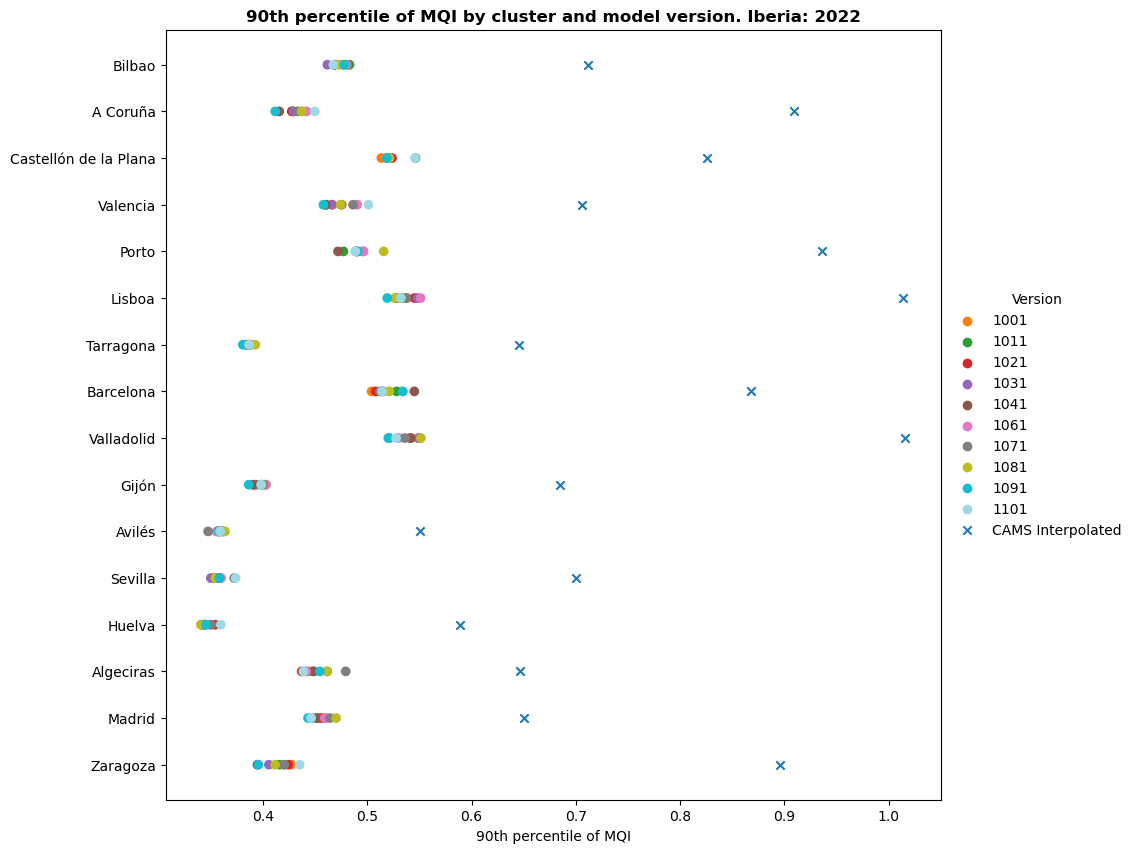

In [151]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()


In [152]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

,cluster,lat,lon,MQI
0,Zaragoza,41.6703,-0.8711,0.42780
1,Madrid,40.4217,-3.6822,0.46460
2,Algeciras,36.1794,-5.3770,0.46318
3,Huelva,37.1903,-6.9045,0.35436
4,Sevilla,37.3843,-5.9596,0.37234
5,Avilés,43.5503,-5.8989,0.36178
6,Gijón,43.5299,-5.6735,0.40260
7,Valladolid,41.6128,-4.7408,0.54977
8,Barcelona,41.4039,2.2045,0.53510
9,Tarragona,41.1159,1.1920,0.38845


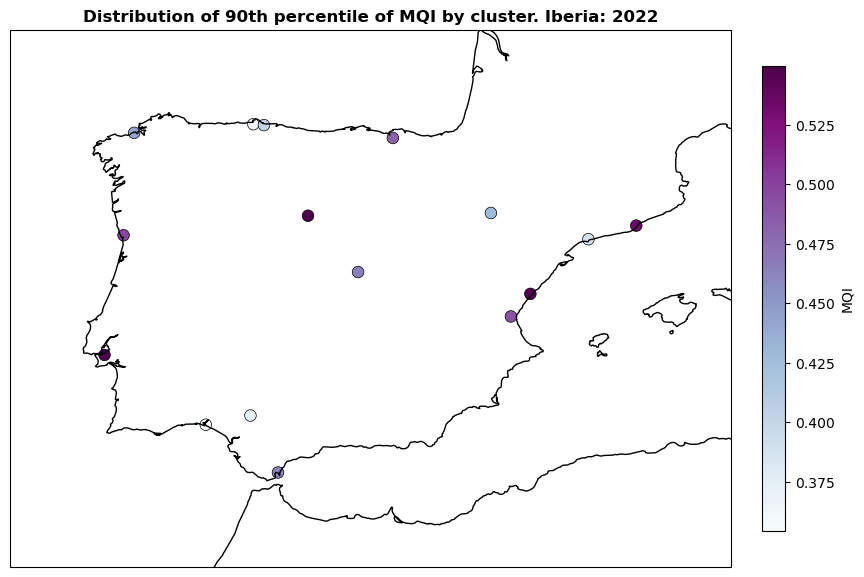

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

## 1.2 Validate 2022 and 2023

In [154]:
date_ini = "2022-01-01 00:00:00"
date_end = "2023-12-31 00:00:00"
cams_version_raw = -1000
model_versions = [1000, 1010, 1020, 1030, 1040, 1060, 1070, 1080, 1090, 1100]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [155]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df = all_df[~(all_df.cluster == 1014)]  # Remove Erandio
all_df

,station_id,version,MQI,fraction,RMSE,beta,RMS_U,bias,CRMSE,cluster,lat,lon
0,ES0041A,-1000,0.822,0.474,20.313,2.0,12.349,-16.017,12.492,1013,43.2588,-2.9457
2,ES0118A,-1000,0.588,0.495,15.858,2.0,13.489,-11.748,10.652,101,40.4217,-3.6822
3,ES0120A,-1000,0.619,0.496,16.398,2.0,13.254,-8.644,13.934,101,40.4517,-3.6772
4,ES0124A,-1000,0.432,0.358,11.267,2.0,13.027,-4.295,10.416,101,40.4400,-3.6392
5,ES0125A,-1000,0.654,0.987,18.967,2.0,14.503,-11.474,15.103,101,40.3469,-3.7050
...,...,...,...,...,...,...,...,...,...,...,...,...
1988,PT03087,1100,0.395,0.034,8.684,2.0,10.999,2.179,8.407,200,38.7050,-9.2103
1989,PT03095,1100,0.332,0.035,7.018,2.0,10.578,1.702,6.808,200,38.6586,-9.0669
1990,PT03097,1100,0.405,0.031,9.243,2.0,11.424,0.594,9.224,200,38.8022,-9.1822
1991,PT03100,1100,0.318,0.024,7.996,2.0,12.592,-1.284,7.892,200,38.7481,-9.2025


In [156]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

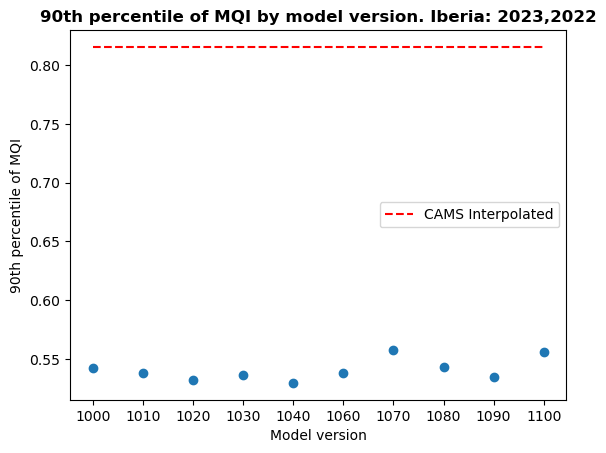

In [157]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots()
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

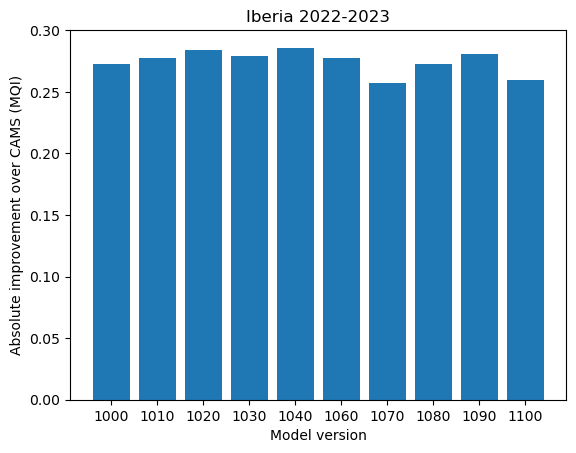

In [158]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.title("Iberia 2022-2023")

plt.show()

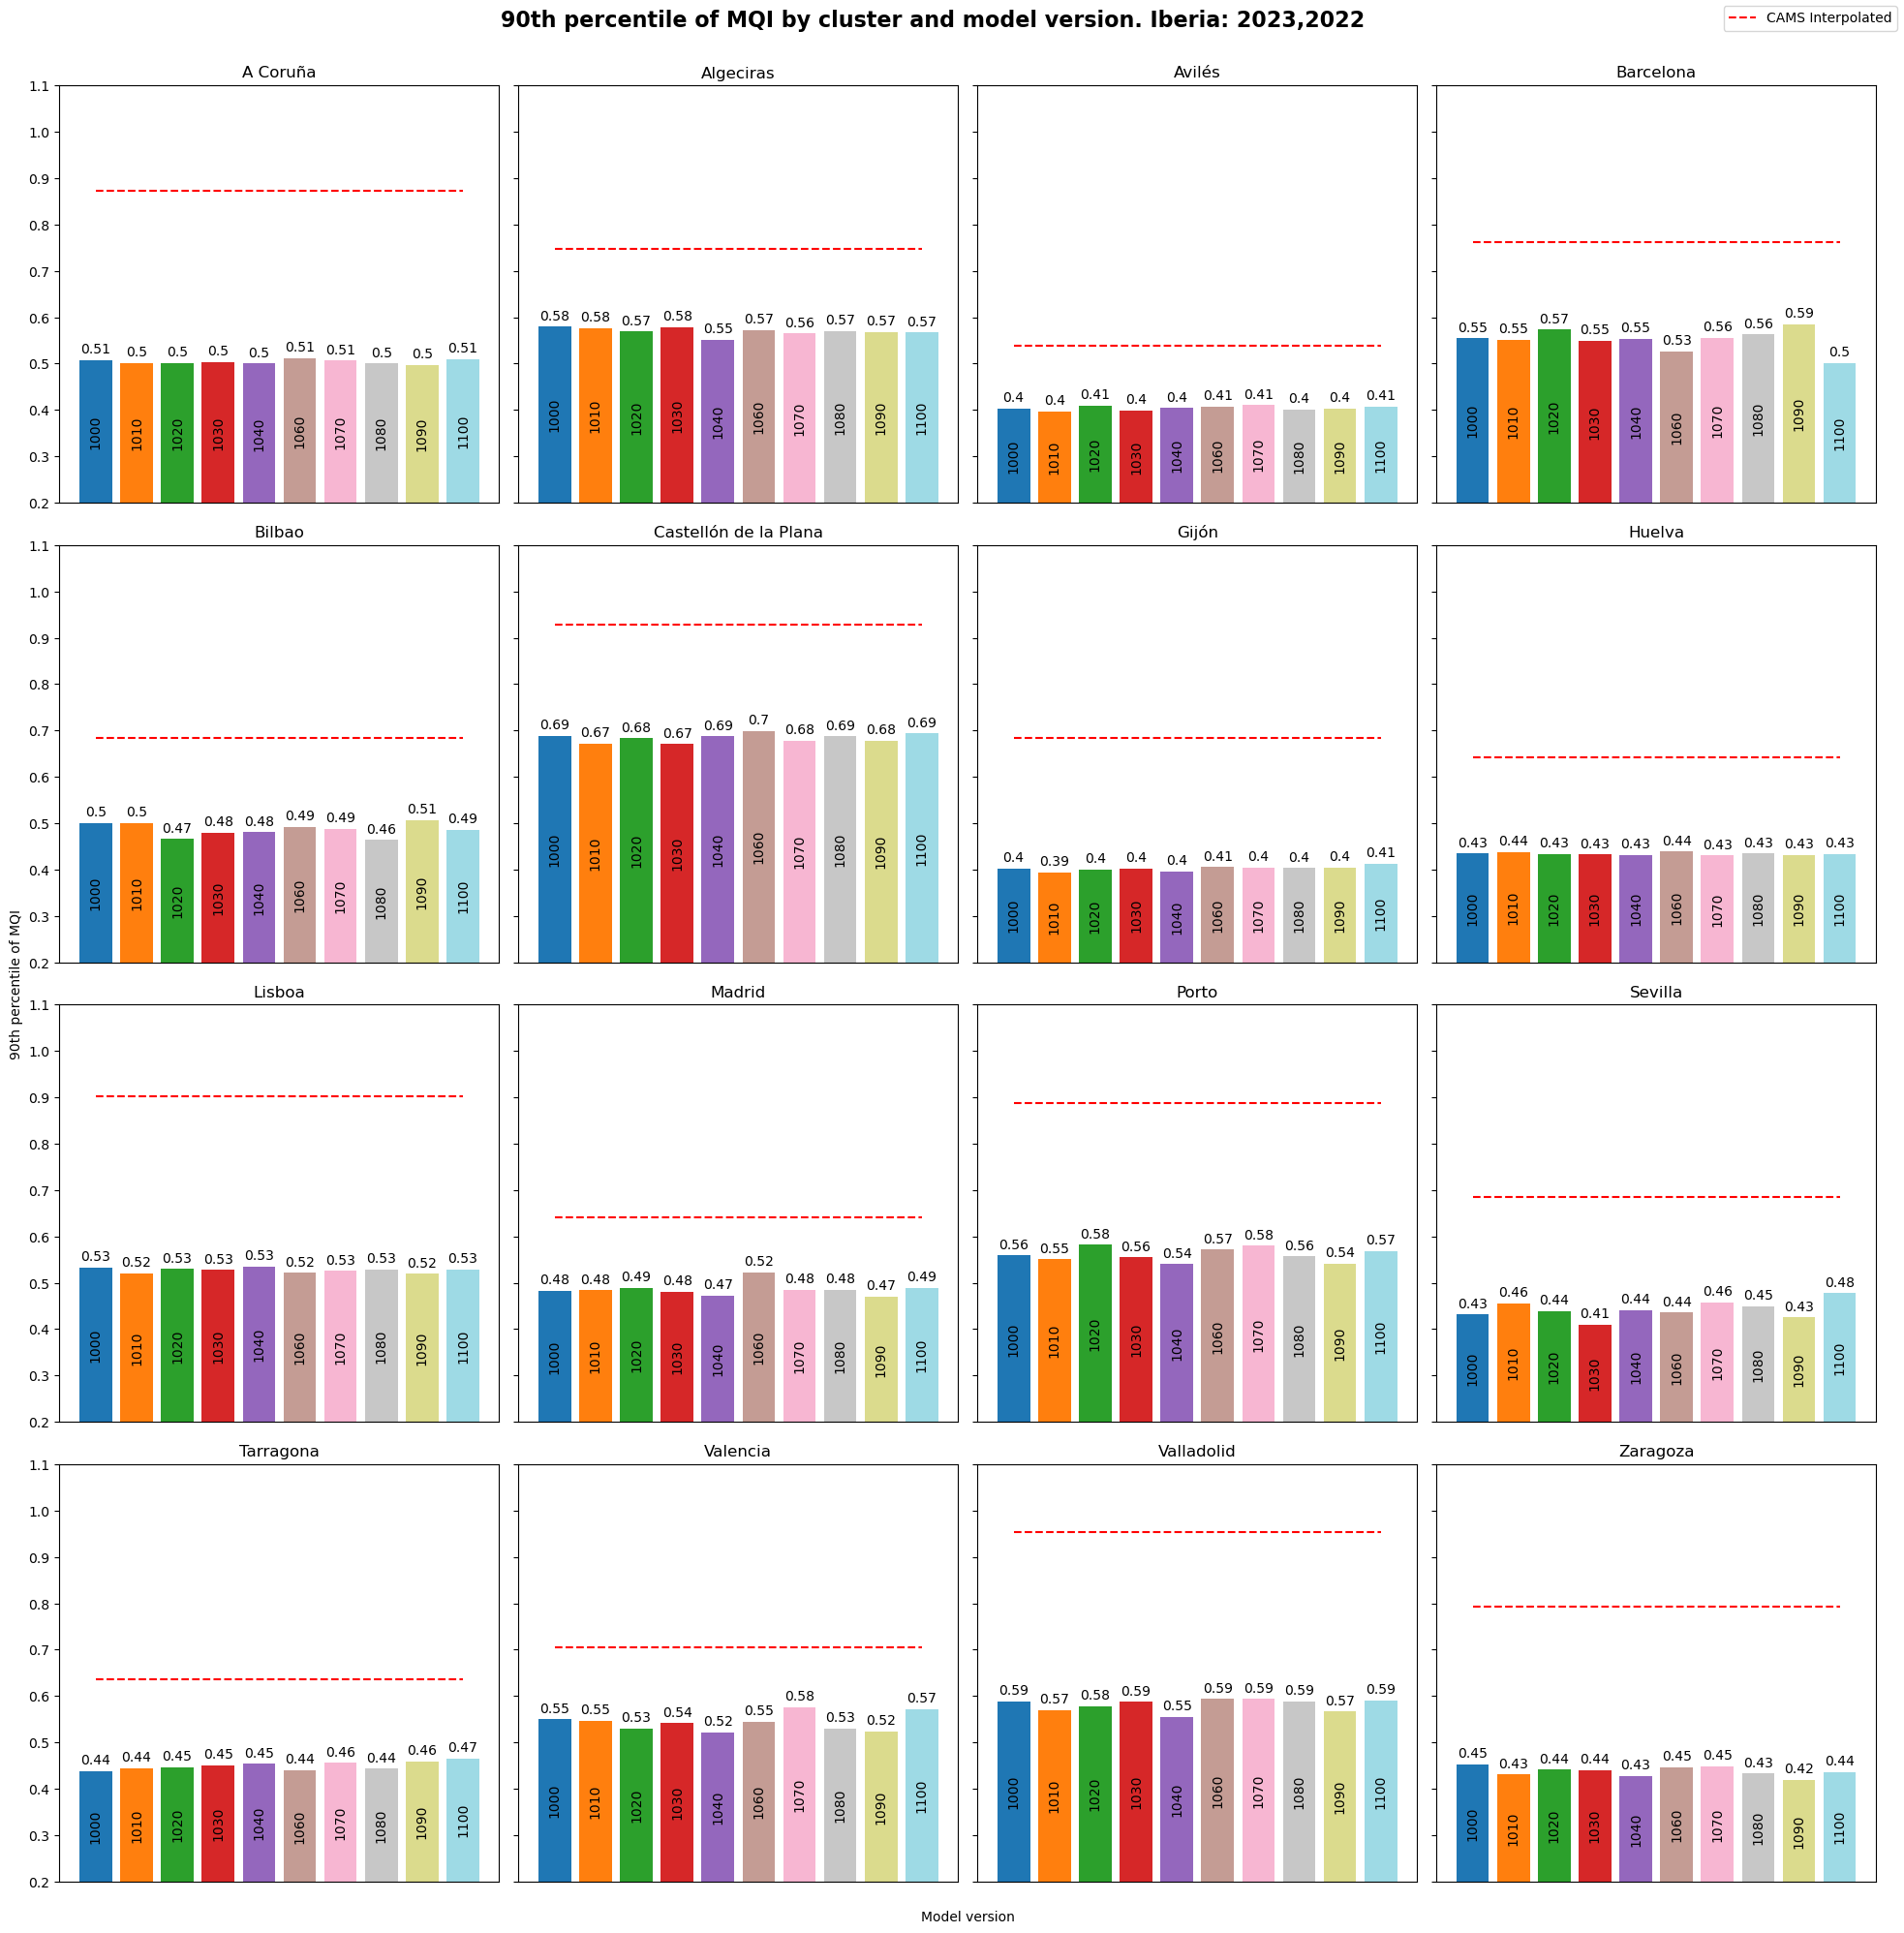

In [159]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, len(df_renamed.index) // 4, figsize=(20, 20), sharex=True, sharey=True)

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i // 4, i % 4].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i // 4, i % 4].bar_label(rects, labels, padding=3)
    ax[i // 4, i % 4].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i // 4, i % 4].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i // 4, i % 4].set_title(cluster)
    ax[i // 4, i % 4].set_ylim(0.2, 1.1)

    
    ax[i // 4, i % 4].set_xticks([])
    ax[i // 4, i % 4].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i // 4, i % 4].set_yticks(np.arange(0.2, 1.15, 0.1))

    handles, labels = ax[i // 4, i % 4].get_legend_handles_labels()

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [160]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

version,-1000,1000,1010,1020,1030,1040,1060,1070,1080,1090,1100
cluster,,,,,,,,,,,
Zaragoza,0.7925,0.4522,0.4309,0.4411,0.4402,0.4273,0.4470,0.4484,0.4328,0.4192,0.4365
Madrid,0.6420,0.4822,0.4840,0.4890,0.4806,0.4730,0.5218,0.4842,0.4844,0.4704,0.4896
Algeciras,0.7480,0.5800,0.5760,0.5690,0.5780,0.5520,0.5730,0.5650,0.5700,0.5680,0.5670
Huelva,0.6432,0.4344,0.4382,0.4338,0.4324,0.4316,0.4388,0.4302,0.4344,0.4314,0.4342
Sevilla,0.6845,0.4317,0.4561,0.4390,0.4097,0.4411,0.4355,0.4575,0.4492,0.4254,0.4777
Avilés,0.5396,0.4031,0.3974,0.4090,0.3995,0.4044,0.4074,0.4106,0.4015,0.4031,0.4067
Gijón,0.6844,0.4022,0.3938,0.3998,0.4022,0.3962,0.4052,0.4044,0.4030,0.4040,0.4128
Valladolid,0.9536,0.5886,0.5703,0.5783,0.5876,0.5545,0.5936,0.5935,0.5890,0.5666,0.5900
Barcelona,0.7631,0.5548,0.5511,0.5733,0.5501,0.5531,0.5270,0.5554,0.5632,0.5851,0.5010


/tmp/ipykernel_57937/1809380653.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=version)


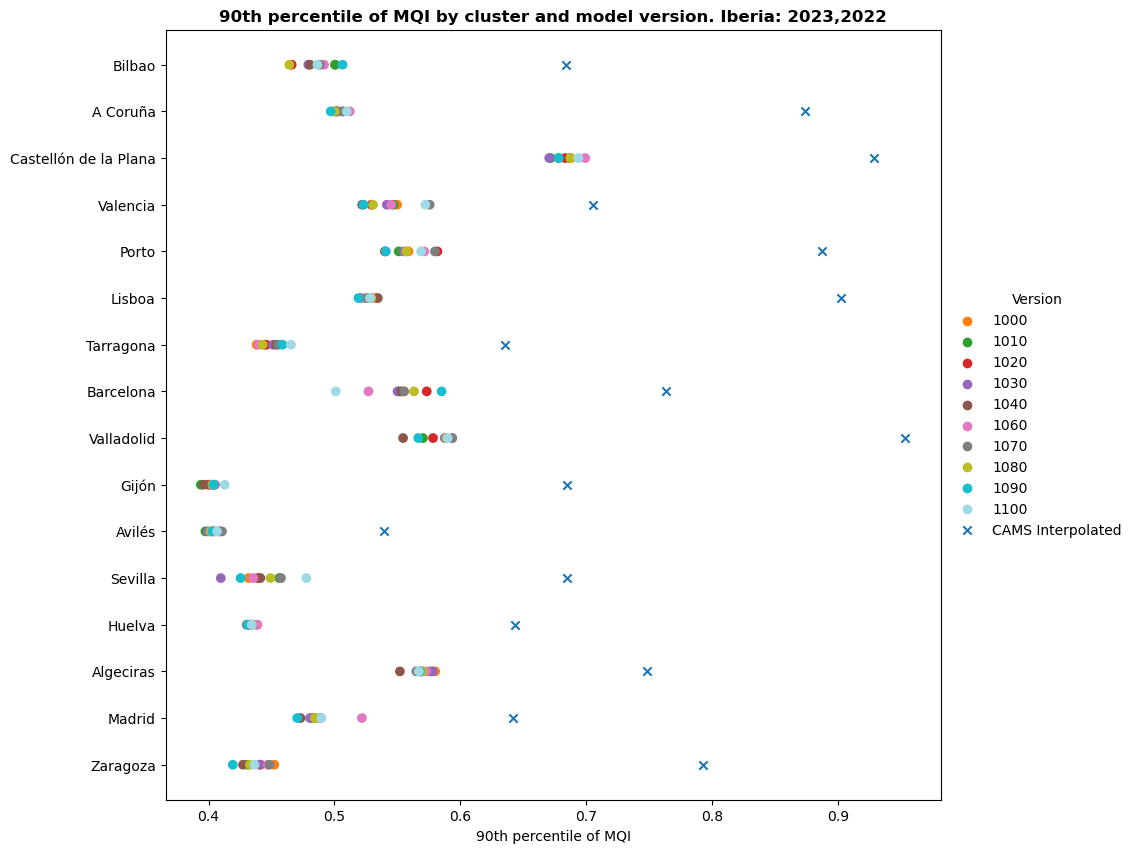

In [161]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()

In [162]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

,cluster,lat,lon,MQI
0,Zaragoza,41.6703,-0.8711,0.44878
1,Madrid,40.4217,-3.6822,0.49282
2,Algeciras,36.1794,-5.3770,0.57820
3,Huelva,37.1903,-6.9045,0.43826
4,Sevilla,37.3843,-5.9596,0.45952
5,Avilés,43.5503,-5.8989,0.40916
6,Gijón,43.5299,-5.6735,0.40596
7,Valladolid,41.6128,-4.7408,0.59351
8,Barcelona,41.4039,2.2045,0.57448
9,Tarragona,41.1159,1.1920,0.45937


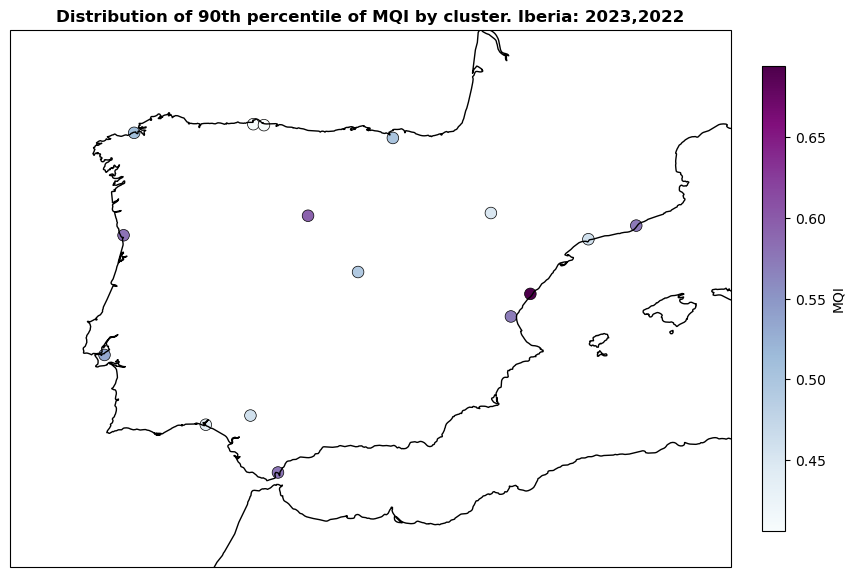

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

# 2. Italy

In [164]:
countries = ["Italy"]
region = "italy"

In [165]:
conn = get_db_connection()
cursor = conn.cursor()
cursor.execute("SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN %s", (countries,))
clusters = cursor.fetchall()
cursor.close()
conn.close()

clusters = pd.DataFrame(clusters, columns=["station_id", "cluster", "lat", "lon"])
clusters

,station_id,cluster,lat,lon
0,IT02258A,401,42.0424,11.8335
1,IT0611A,406,37.1824,15.1288
2,IT0614A,406,37.1561,15.1909
3,IT0618A,406,37.2184,15.2205
4,IT0620A,406,37.0984,15.2625
5,IT0825A,402,41.9474,12.4696
6,IT0828A,402,41.8831,12.5090
7,IT0854A,400,44.4182,8.9274
8,IT0856A,400,44.4076,8.9410
9,IT0858A,400,44.3949,8.9915


## 2.1 Validate 2022

In [166]:
date_ini = "2022-01-01 00:00:00"
date_end = "2022-12-31 00:00:00"
cams_version_raw = -10001
model_versions = [10011, 10111, 10211, 10311, 10411, 10611, 10711, 10811, 10911, 11011]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [167]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

,station_id,version,MQI,fraction,RMSE,beta,RMS_U,bias,CRMSE,cluster,lat,lon
0,IT02258A,-10001,0.520,0.945,10.554,2.0,10.141,-5.865,8.774,401,42.0424,11.8335
1,IT0611A,-10001,0.395,0.733,7.918,2.0,10.023,-0.917,7.865,406,37.1824,15.1288
2,IT0614A,-10001,0.574,0.833,12.111,2.0,10.545,-4.856,11.095,406,37.1561,15.1909
3,IT0618A,-10001,0.469,0.733,9.661,2.0,10.308,-3.511,9.000,406,37.2184,15.2205
4,IT0620A,-10001,0.538,0.807,11.123,2.0,10.336,-4.037,10.364,406,37.0984,15.2625
...,...,...,...,...,...,...,...,...,...,...,...,...
523,IT2264A,11011,0.580,0.066,13.438,2.0,11.589,0.082,13.438,401,42.0969,11.7883
524,IT2277A,11011,0.442,0.038,8.741,2.0,9.894,5.172,7.047,403,40.7989,14.1794
525,IT2278A,11011,0.476,0.065,10.764,2.0,11.307,-1.273,10.688,405,44.3329,8.5120
526,IT2286A,11011,0.408,0.071,8.604,2.0,10.532,0.199,8.602,405,44.2618,8.4457


In [168]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

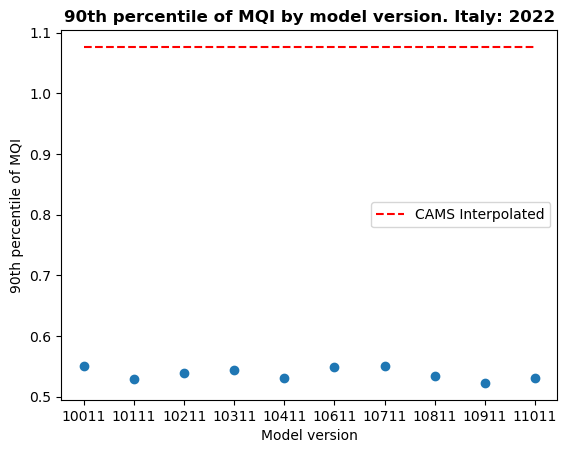

In [169]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots()
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

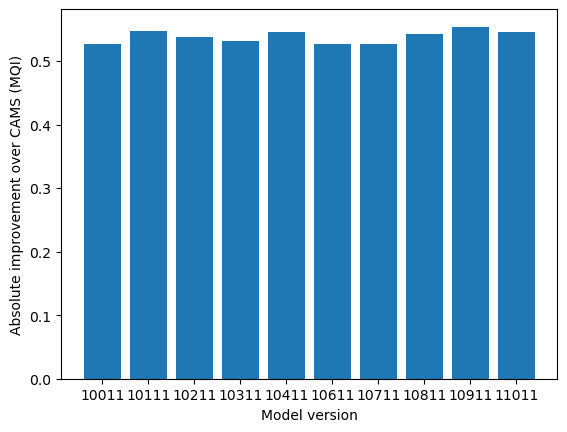

In [170]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()

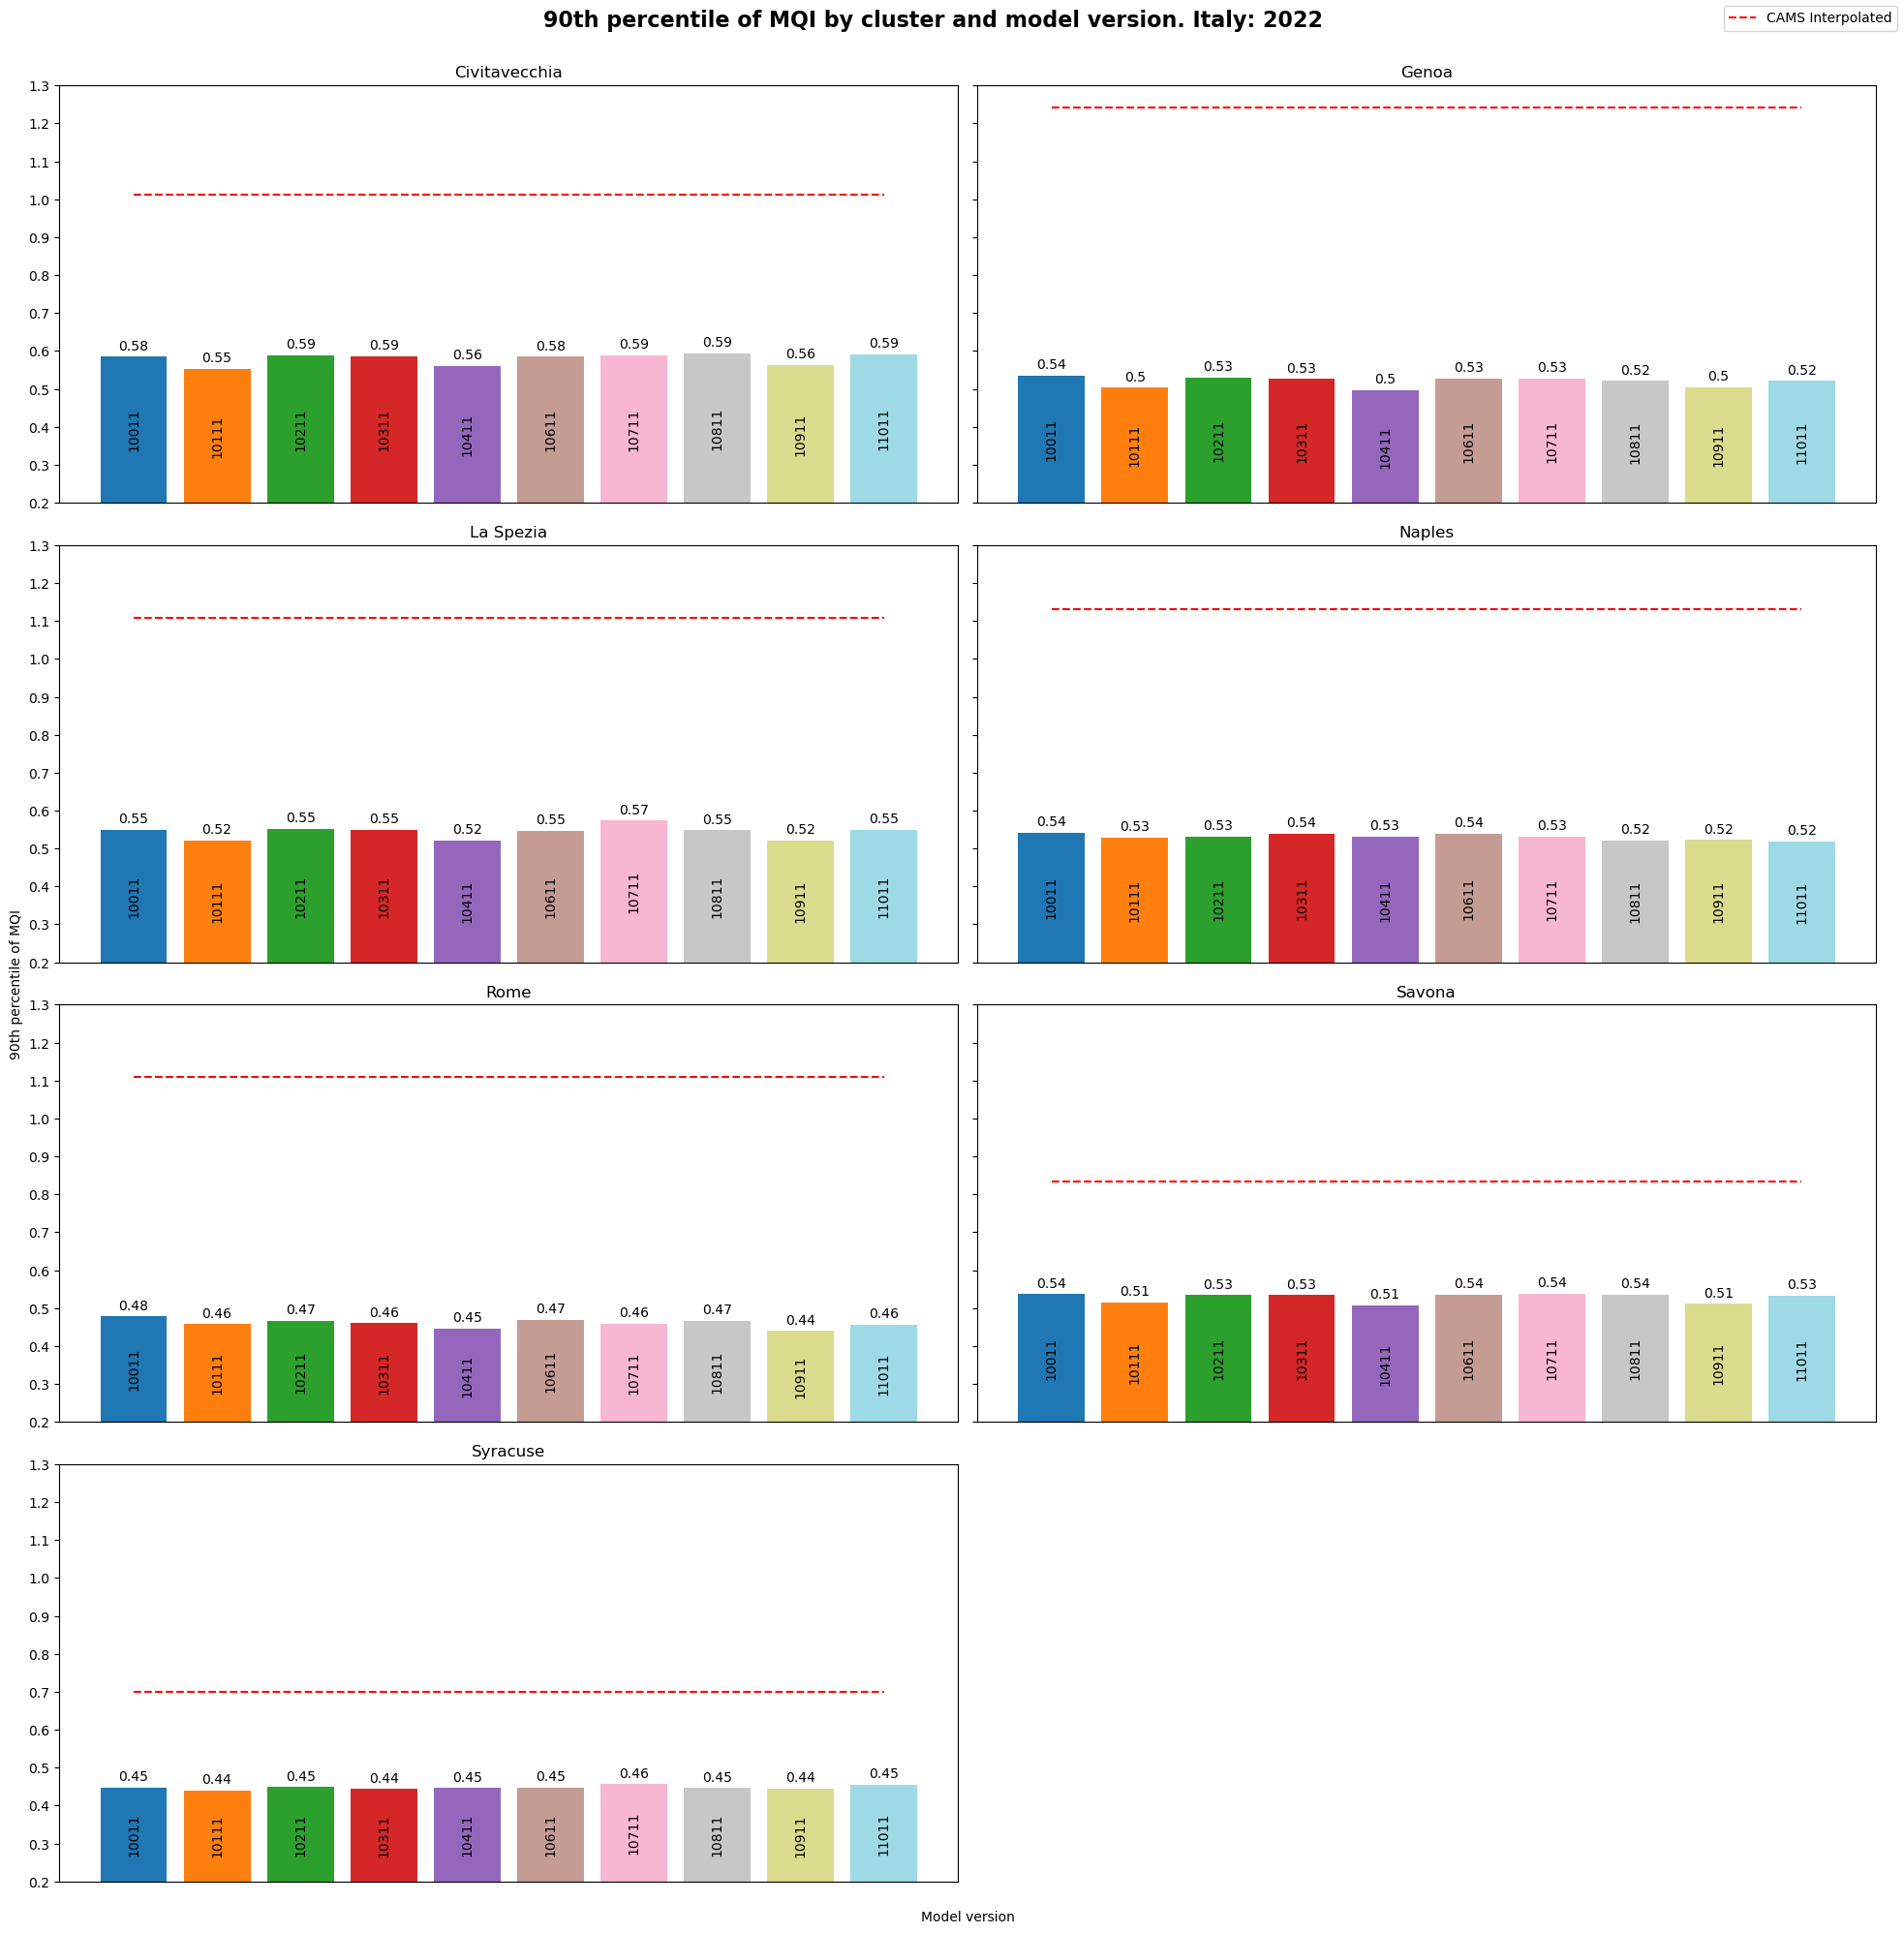

In [171]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=True)

ax = ax.ravel()

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i].bar_label(rects, labels, padding=3)
    ax[i].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i].set_title(cluster)
    ax[i].set_ylim(0.2, 1.3)

    
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i].set_yticks(np.arange(0.2, 1.35, 0.1))

    handles, labels = ax[i].get_legend_handles_labels()

ax[-1].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [172]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

version,-10001,10011,10111,10211,10311,10411,10611,10711,10811,10911,11011
cluster,,,,,,,,,,,
Genoa,1.2415,0.5350,0.5030,0.5295,0.5260,0.4960,0.5280,0.5270,0.5215,0.5045,0.5210
Civitavecchia,1.0110,0.5850,0.5535,0.5885,0.5870,0.5605,0.5850,0.5890,0.5945,0.5635,0.5905
Rome,1.1100,0.4778,0.4576,0.4662,0.4598,0.4452,0.4690,0.4594,0.4662,0.4396,0.4564
Naples,1.1300,0.5420,0.5296,0.5316,0.5398,0.5307,0.5397,0.5319,0.5212,0.5225,0.5191
La Spezia,1.1090,0.5498,0.5218,0.5512,0.5498,0.5208,0.5464,0.5738,0.5484,0.5208,0.5494
Savona,0.8332,0.5364,0.5144,0.5344,0.5342,0.5068,0.5352,0.5382,0.5356,0.5110,0.5324
Syracuse,0.7010,0.4468,0.4404,0.4488,0.4436,0.4458,0.4478,0.4564,0.4462,0.4446,0.4544


/tmp/ipykernel_57937/2147851652.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=version)


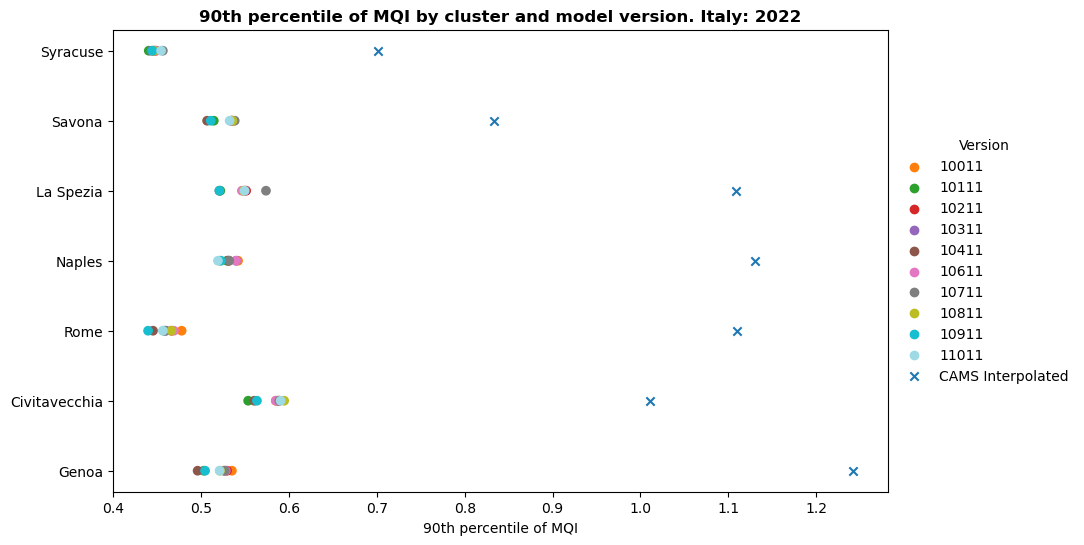

In [173]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()


In [174]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

,cluster,lat,lon,MQI
0,Genoa,44.4182,8.9274,0.53005
1,Civitavecchia,42.0424,11.8335,0.59090
2,Rome,41.9474,12.4696,0.46988
3,Naples,40.8542,14.2513,0.54002
4,La Spezia,44.1108,9.8321,0.55346
5,Savona,44.2725,8.4389,0.53658
6,Syracuse,37.1824,15.1288,0.45460


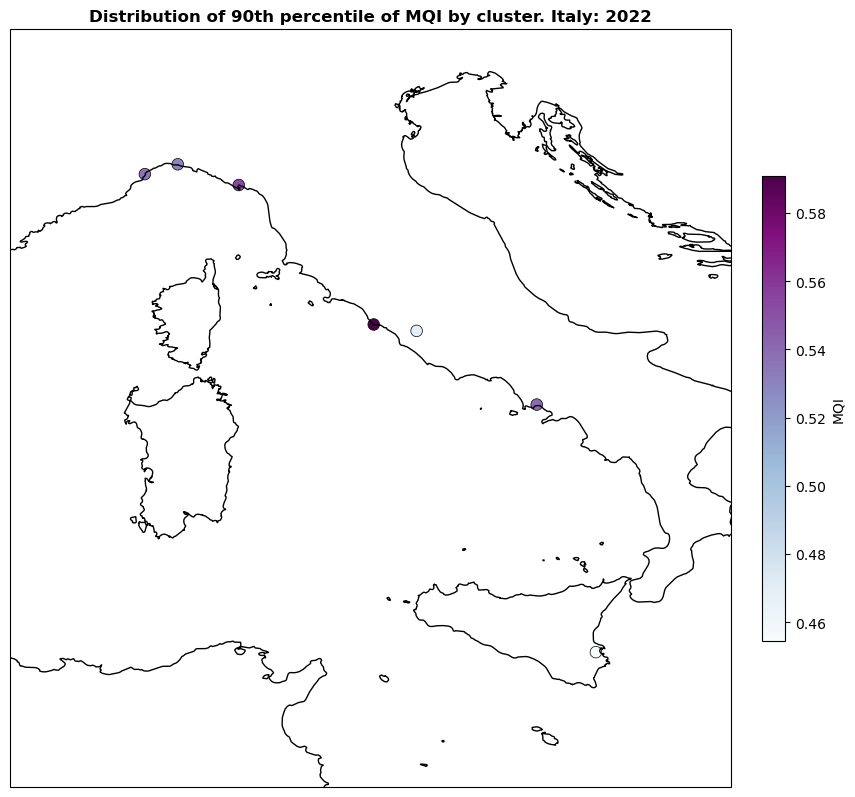

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

## 2.2 Validate 2022 and 2023

In [176]:
date_ini = "2022-01-01 00:00:00"
date_end = "2023-12-31 00:00:00"
cams_version_raw = -10001
model_versions = [10001, 10101, 10201, 10301, 10401, 10601, 10701, 10801, 10901, 11001]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [177]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

,station_id,version,MQI,fraction,RMSE,beta,RMS_U,bias,CRMSE,cluster,lat,lon
0,IT02258A,-10001,0.520,0.472,10.554,2.0,10.141,-5.865,8.774,401,42.0424,11.8335
1,IT0611A,-10001,0.389,0.493,7.800,2.0,10.030,-0.819,7.757,406,37.1824,15.1288
2,IT0614A,-10001,0.578,0.546,12.230,2.0,10.586,-4.751,11.269,406,37.1561,15.1909
3,IT0618A,-10001,0.479,0.496,9.891,2.0,10.335,-3.204,9.357,406,37.2184,15.2205
4,IT0620A,-10001,0.538,0.403,11.123,2.0,10.336,-4.037,10.364,406,37.0984,15.2625
...,...,...,...,...,...,...,...,...,...,...,...,...
523,IT2264A,11001,0.686,0.045,16.825,2.0,12.262,-4.020,16.338,401,42.0969,11.7883
524,IT2277A,11001,0.510,0.017,10.223,2.0,10.014,3.931,9.437,403,40.7989,14.1794
525,IT2278A,11001,0.474,0.027,10.553,2.0,11.135,-1.529,10.442,405,44.3329,8.5120
526,IT2286A,11001,0.347,0.041,7.232,2.0,10.425,0.719,7.196,405,44.2618,8.4457


In [178]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

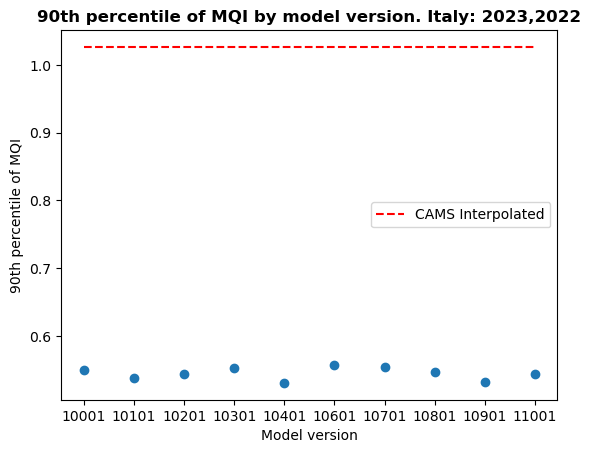

In [179]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots()
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

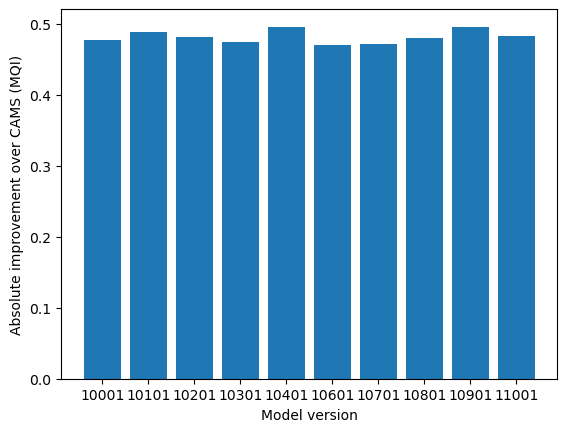

In [180]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()

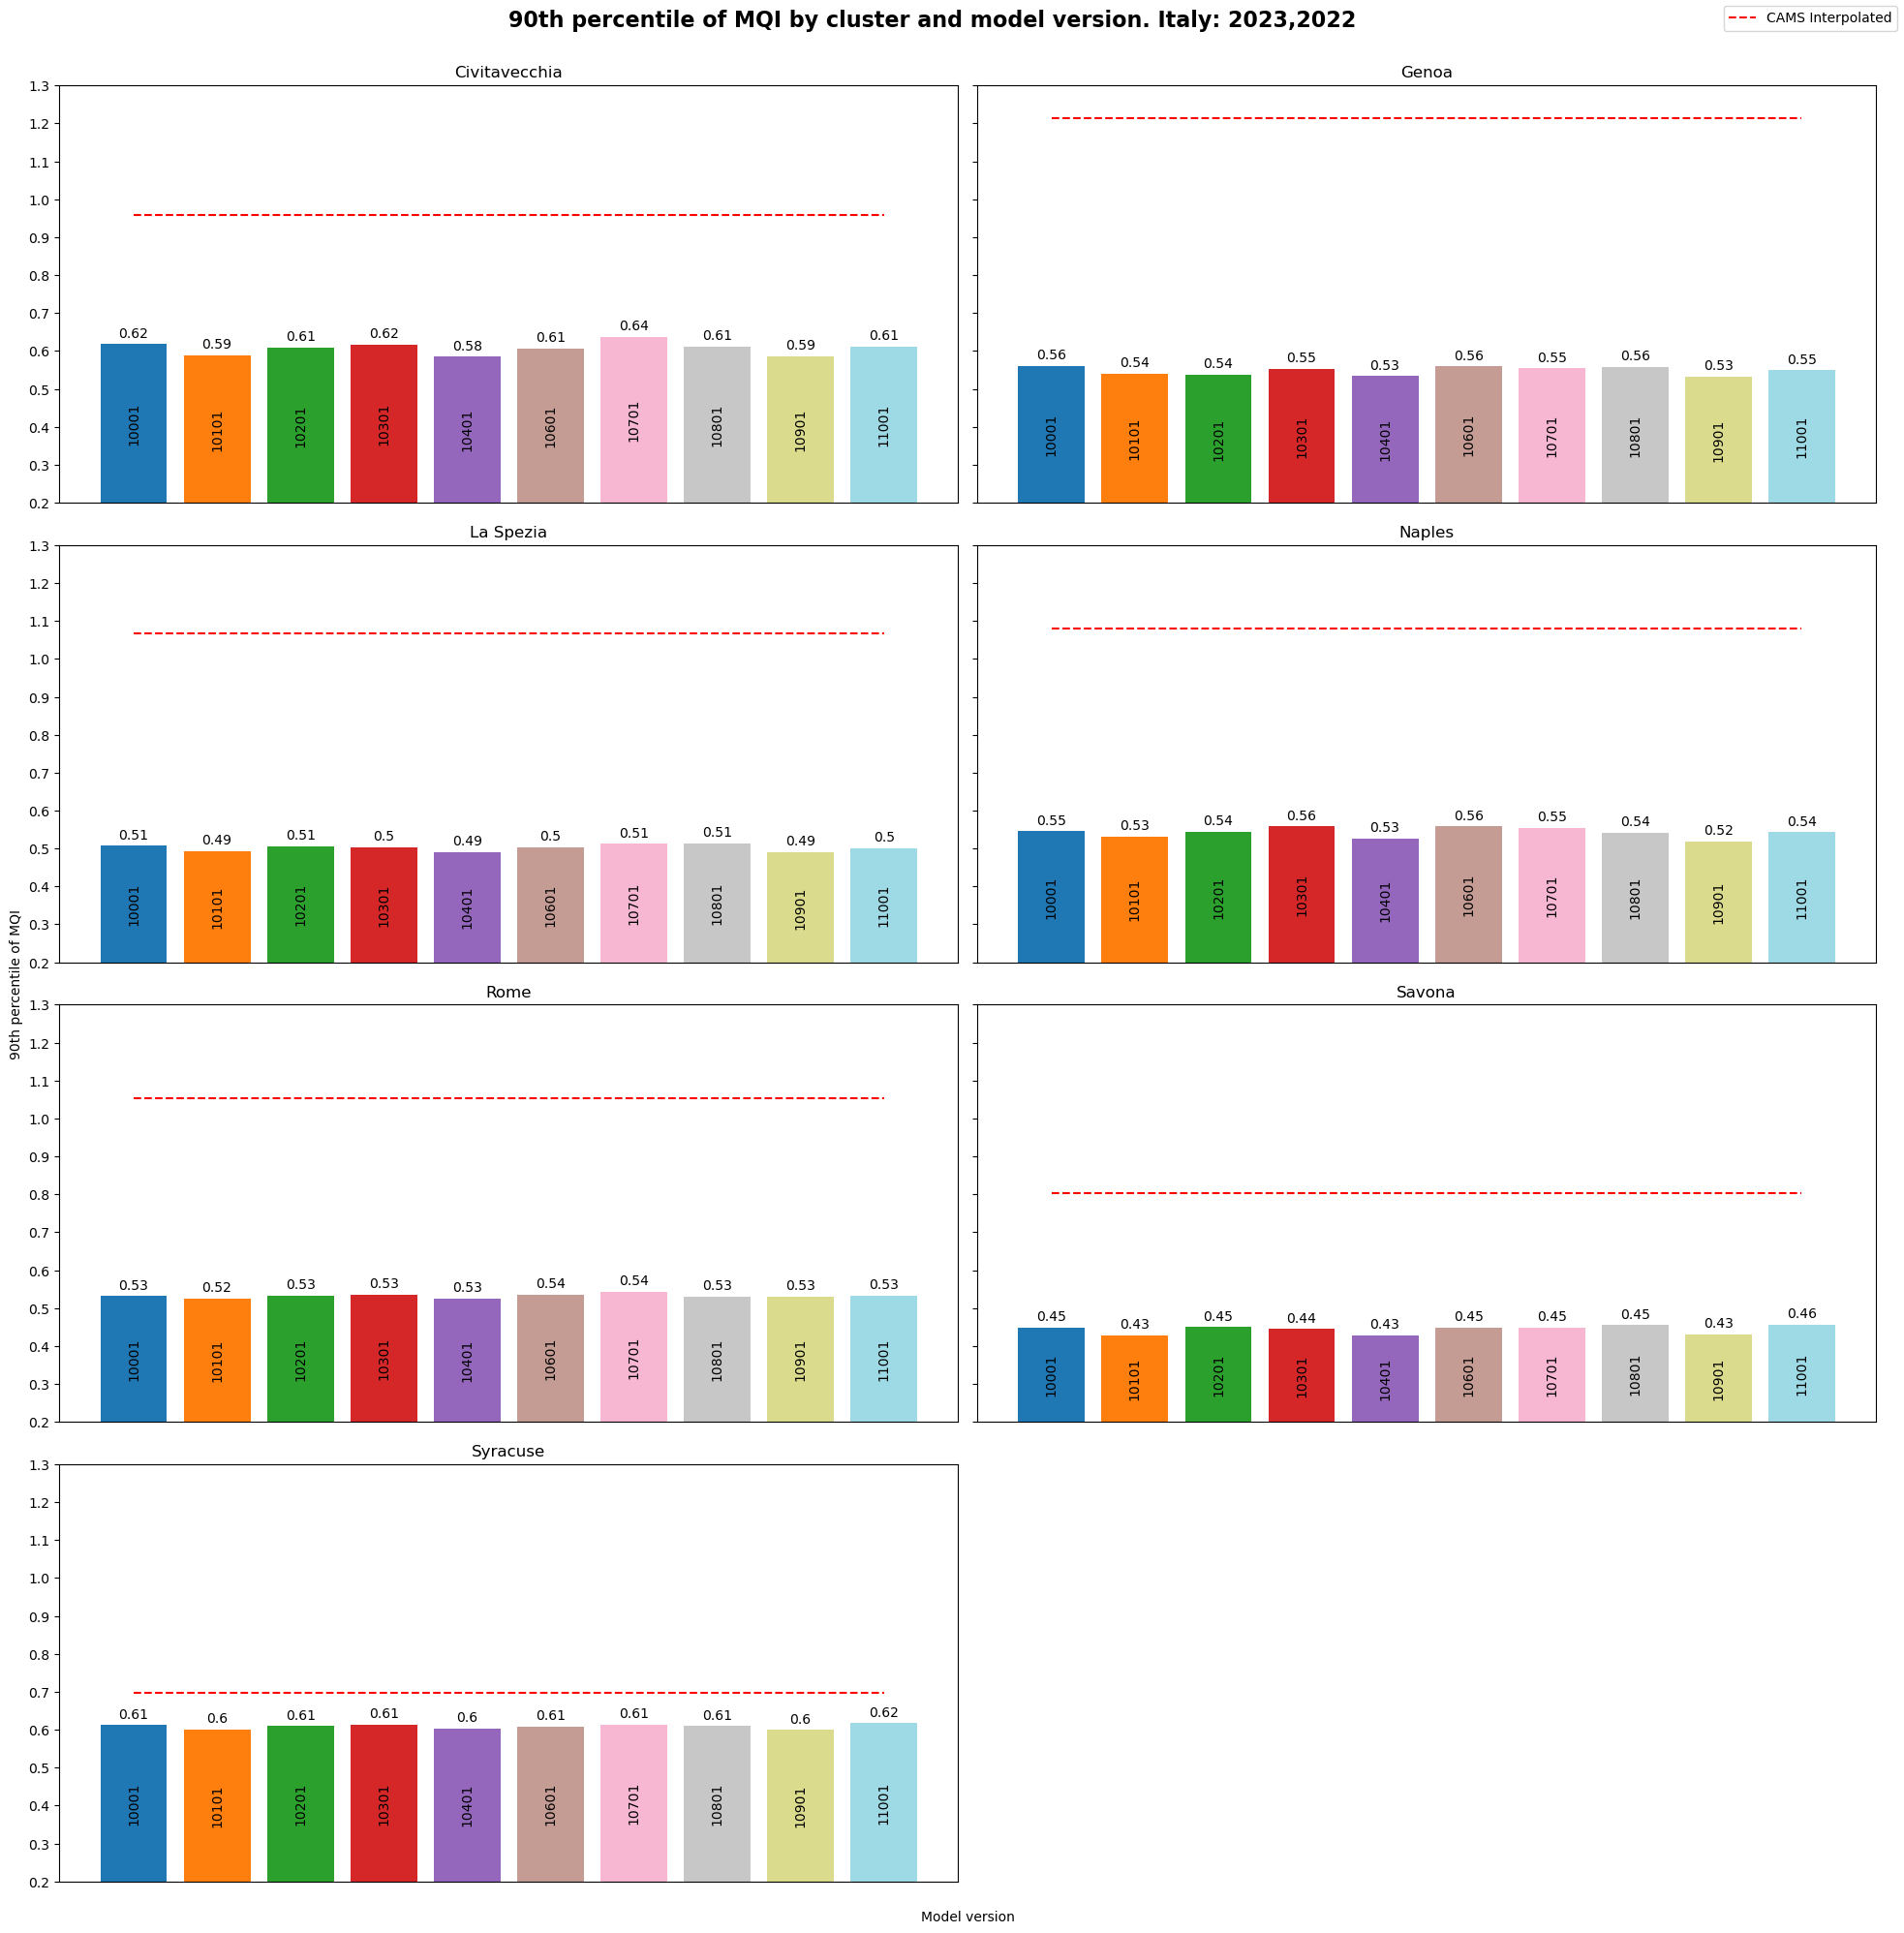

In [181]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=True)

ax = ax.ravel()

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i].bar_label(rects, labels, padding=3)
    ax[i].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i].set_title(cluster)
    ax[i].set_ylim(0.2, 1.3)

    
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i].set_yticks(np.arange(0.2, 1.35, 0.1))

    handles, labels = ax[i].get_legend_handles_labels()

ax[-1].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.show()

In [182]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

version,-10001,10001,10101,10201,10301,10401,10601,10701,10801,10901,11001
cluster,,,,,,,,,,,
Genoa,1.2135,0.5615,0.5405,0.5380,0.5530,0.5340,0.5595,0.5540,0.5575,0.5325,0.5495
Civitavecchia,0.9595,0.6180,0.5885,0.6095,0.6165,0.5850,0.6060,0.6365,0.6115,0.5870,0.6125
Rome,1.0528,0.5312,0.5248,0.5334,0.5348,0.5260,0.5360,0.5428,0.5308,0.5308,0.5336
Naples,1.0803,0.5454,0.5310,0.5443,0.5583,0.5263,0.5579,0.5539,0.5417,0.5187,0.5428
La Spezia,1.0670,0.5070,0.4934,0.5056,0.5036,0.4904,0.5034,0.5124,0.5142,0.4900,0.5008
Savona,0.8030,0.4494,0.4274,0.4496,0.4448,0.4286,0.4492,0.4492,0.4546,0.4304,0.4560
Syracuse,0.6964,0.6120,0.6000,0.6098,0.6130,0.6040,0.6090,0.6142,0.6096,0.5990,0.6170


/tmp/ipykernel_57937/2147851652.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=version)


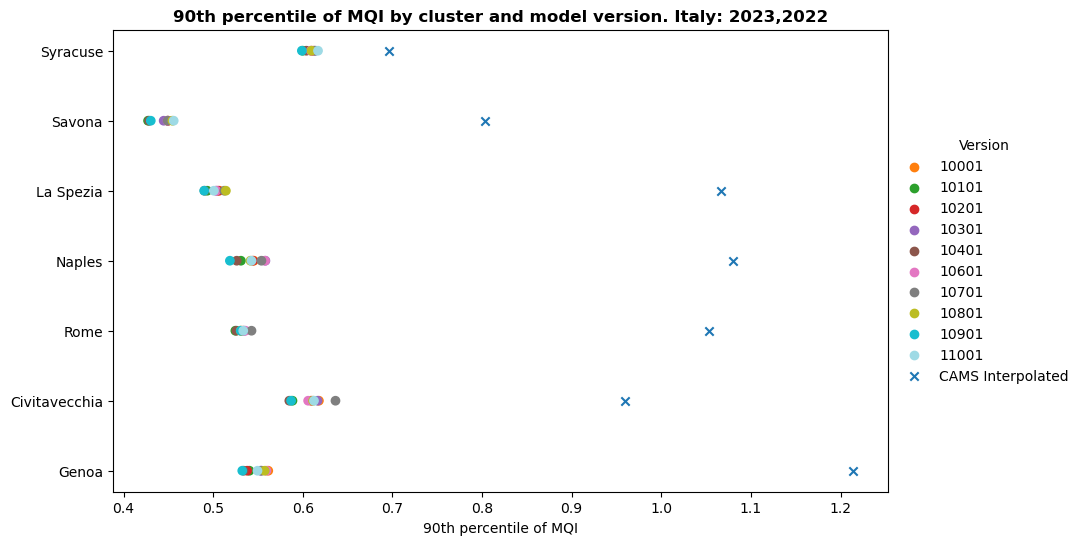

In [183]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()


In [184]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

,cluster,lat,lon,MQI
0,Genoa,44.4182,8.9274,0.55970
1,Civitavecchia,42.0424,11.8335,0.61985
2,Rome,41.9474,12.4696,0.53668
3,Naples,40.8542,14.2513,0.55794
4,La Spezia,44.1108,9.8321,0.51258
5,Savona,44.2725,8.4389,0.45474
6,Syracuse,37.1824,15.1288,0.61448


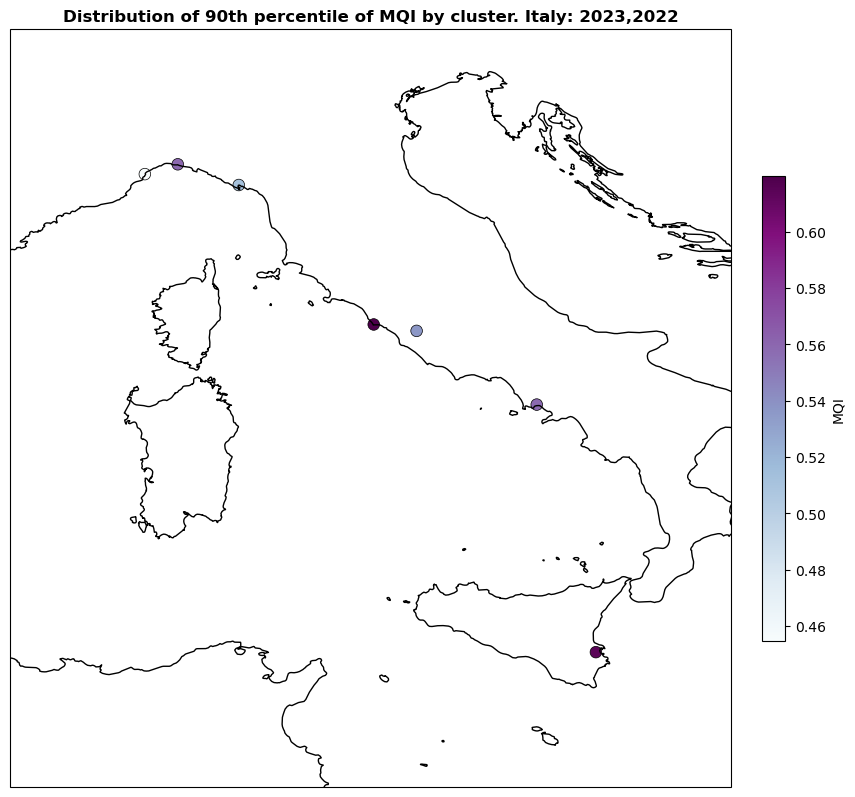

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()

# 3. Poland

In [186]:
countries = ["Poland"]
region = "poland"

In [187]:
conn = get_db_connection()
cursor = conn.cursor()
cursor.execute("SELECT station_id, cluster, lat, lon FROM stations WHERE cluster IS NOT NULL AND country IN %s", (countries,))
clusters = cursor.fetchall()
cursor.close()
conn.close()

clusters = pd.DataFrame(clusters, columns=["station_id", "cluster", "lat", "lon"])
clusters

,station_id,cluster,lat,lon
0,PL0008A,503,50.2646,18.9750
1,PL0039A,500,50.0693,20.0535
2,PL0045A,502,54.3533,18.6353
3,PL0047A,502,54.4008,18.6575
4,PL0048A,502,54.5608,18.4933
5,PL0052A,502,54.3803,18.6203
6,PL0129A,501,52.4076,20.9559
7,PL0134A,501,52.1917,20.8375
8,PL0140A,501,52.2193,21.0047
9,PL0143A,501,52.2909,21.0425


## 3.1 Validate 2022

*Note: Poland only has 2022 available*

In [188]:
date_ini = "2022-01-01 00:00:00"
date_end = "2022-12-31 00:00:00"
cams_version_raw = -10002
model_versions = [10012, 10112, 10212, 10312, 10412, 10612, 10712, 10812, 10912, 11012]

date_ini_dt = dt.datetime.strptime(date_ini, "%Y-%m-%d %H:%M:%S")
date_end_dt = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M:%S")

In [189]:
all_df = []

all_df.append(get_validation_data(cams_version_raw, date_ini, date_end))
for model_version in model_versions:
    all_df.append(get_validation_data(model_version, date_ini, date_end))

all_df = pd.concat(all_df)
all_df = pd.merge(all_df, clusters, on="station_id", how="left")
all_df

,station_id,version,MQI,fraction,RMSE,beta,RMS_U,bias,CRMSE,cluster,lat,lon
0,PL0008A,-10002,0.580,0.995,13.546,2.0,11.687,-6.469,11.901,503,50.2646,18.9750
1,PL0039A,-10002,0.598,0.972,13.567,2.0,11.350,-7.470,11.325,500,50.0693,20.0535
2,PL0045A,-10002,0.517,0.980,11.197,2.0,10.833,-5.110,9.964,502,54.3533,18.6353
3,PL0047A,-10002,0.552,0.979,11.960,2.0,10.830,-5.500,10.620,502,54.4008,18.6575
4,PL0048A,-10002,0.283,0.977,5.660,2.0,10.006,-1.526,5.450,502,54.5608,18.4933
...,...,...,...,...,...,...,...,...,...,...,...,...
270,PL0618A,11012,0.398,0.060,8.781,2.0,11.025,-2.054,8.537,500,50.0075,20.2592
271,PL0640A,11012,0.394,0.060,8.428,2.0,10.706,-0.895,8.380,500,50.0250,19.7268
272,PL0641A,11012,0.375,0.052,9.041,2.0,12.057,-0.980,8.988,500,50.0574,19.9460
273,PL0739A,11012,0.366,0.063,8.813,2.0,12.050,-1.802,8.626,501,52.2077,20.9061


In [190]:
q90_by_version = all_df.groupby("version").MQI.quantile(0.9)
q90_by_cluster_version = pd.pivot_table(all_df, index="cluster", columns="version", values="MQI", aggfunc=lambda x: np.percentile(x, 90))

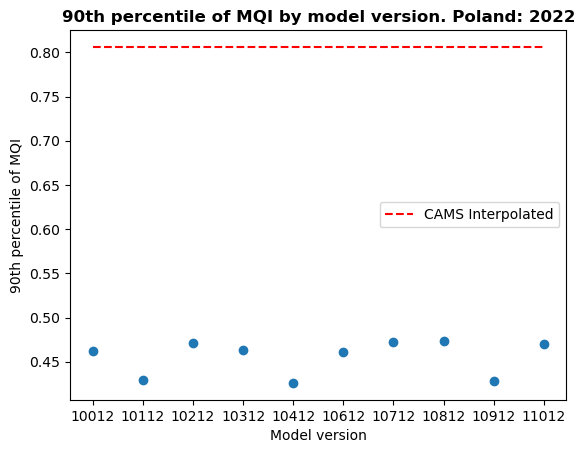

In [191]:
# Plot q90_by_version as points.
versions = q90_by_version.index.values
values = q90_by_version.values

fig, ax = plt.subplots()
ax.scatter(versions[1:], values[1:])
ax.hlines(values[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")

ax.set_xlabel("Model version")
ax.set_ylabel("90th percentile of MQI")

ax.set_xticks(versions[1:])
ax.set_xticklabels(versions[1:])

# Legend outside the plot. lower center
ax.legend(loc="center right")
plt.title(f'90th percentile of MQI by model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

plt.show()

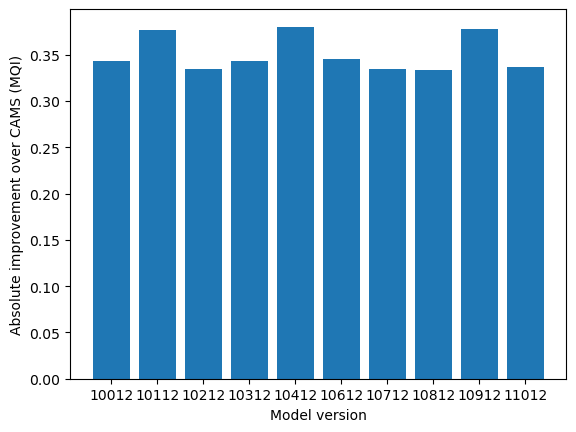

In [192]:
# Improvement over CAMS
versions = q90_by_version.index.values[1:]
values = q90_by_version.values
values = values[0] - values
values = values[1:]

fig, ax = plt.subplots()
ax.bar(versions, values)

ax.set_xlabel("Model version")
ax.set_ylabel("Absolute improvement over CAMS (MQI)")

plt.show()

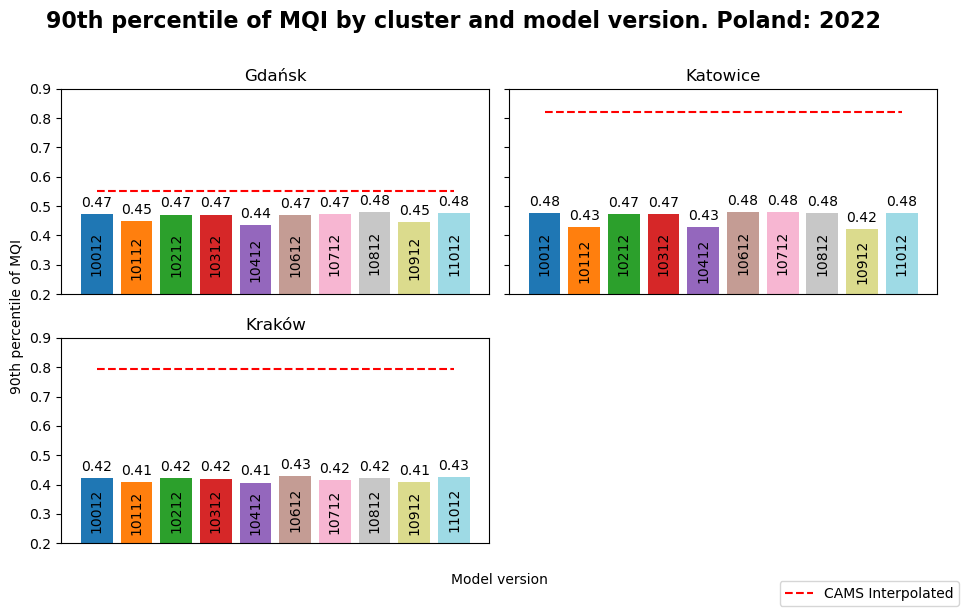

In [193]:
# Modify the index of q90_by_cluster_version to use cluster names.
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed = df_renamed.sort_index()
versions = df_renamed.columns.values.copy()
versions[0] = "CAMS"
colors = plt.get_cmap('tab20', len(versions[1:])).colors

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

ax = ax.ravel()

for i, cluster in enumerate(df_renamed.index):
    rects = ax[i].bar(df_renamed.columns[1:], df_renamed.loc[cluster][1:], color=colors)
    labels = np.round(df_renamed.loc[cluster][1:].values, 2)
    ax[i].bar_label(rects, labels, padding=3)
    ax[i].bar_label(rects, versions[1:], label_type="center", rotation=90)
    ax[i].hlines(df_renamed.loc[cluster].iloc[0], versions[1], versions[-1], colors="r", linestyles="dashed", label="CAMS Interpolated")
    ax[i].set_title(cluster)
    ax[i].set_ylim(0.2, 0.9)
    
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])

    # Set y-ticks with 0.1 step
    ax[i].set_yticks(np.arange(0.2, 0.95, 0.1))

    handles, labels = ax[i].get_legend_handles_labels()

ax[-1].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)

fig.suptitle(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=16)
ax_main = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_main.set_ylabel("90th percentile of MQI")
ax_main.set_xlabel("Model version")
fig.legend(handles, labels, loc='lower right')

plt.tight_layout()

plt.show()

In [194]:
df_renamed = q90_by_cluster_version.copy()
df_renamed.index = df_renamed.index.map(lambda x: config["places"]["cluster_names"][x])
df_renamed.transpose()
df_renamed

version,-10002,10012,10112,10212,10312,10412,10612,10712,10812,10912,11012
cluster,,,,,,,,,,,
Kraków,0.7948,0.4226,0.4074,0.4222,0.4202,0.4068,0.4274,0.4166,0.4222,0.4098,0.4258
Warsaw,0.9345,0.4385,0.3900,0.4425,0.4330,0.3845,0.4355,0.4390,0.4410,0.3845,0.4395
Gdańsk,0.5504,0.4722,0.4476,0.4712,0.4712,0.4366,0.4708,0.4722,0.4792,0.4452,0.4770
Katowice,0.8208,0.4776,0.4298,0.4720,0.4718,0.4286,0.4784,0.4790,0.4768,0.4230,0.4758


/tmp/ipykernel_57937/3214867382.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=version)


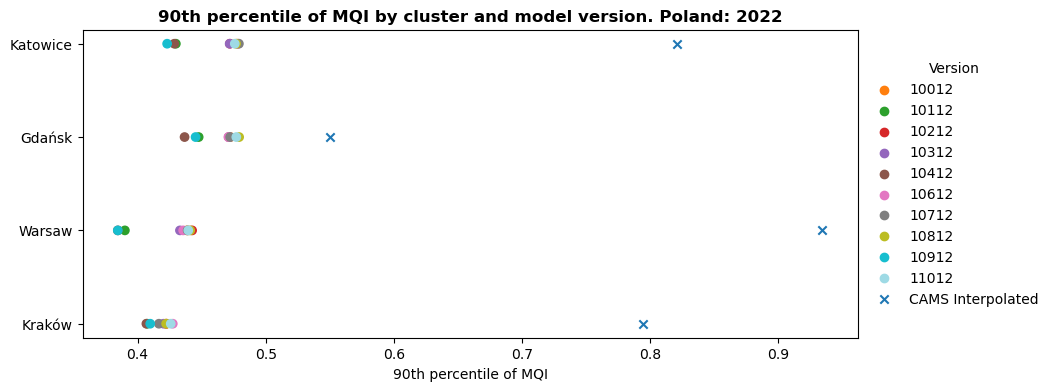

In [195]:
colors = plt.get_cmap('tab20', len(df_renamed.columns)).colors
legend = df_renamed.columns.values
legend[0] = "CAMS"

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i, row in enumerate(df_renamed.iterrows()):
    cluster, values = row
    ax.scatter(values[1:], [i] * len(values[1:]), c=colors[1:])
    ax.scatter(values.iloc[0], i, color=colors[0], marker="x")

ax.set_yticks(range(len(df_renamed.index)))
ax.set_yticklabels(df_renamed.index)
ax.set_xlabel("90th percentile of MQI")

# Add legend for each version
for i, version in enumerate(list(legend[1:])):
    i = i+1
    plt.scatter([], [], c=colors[i], label=version)
plt.scatter([], [], color=colors[0], marker="x", label="CAMS Interpolated")
plt.legend(scatterpoints=1, frameon=False, labelspacing=0.5, title='Version', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'90th percentile of MQI by cluster and model version. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             y=1, fontweight='bold', fontsize=12)

plt.show()

In [196]:
q90_map = q90_by_cluster_version.iloc[:, 1:].quantile(0.9, axis=1)
items = []
for i in q90_map.items():
    #lat = clusters[clusters.cluster == i[0]].lat.mean()
    #lon = clusters[clusters.cluster == i[0]].lon.mean()
    lat = clusters[clusters.cluster == i[0]].lat.values[0]
    lon = clusters[clusters.cluster == i[0]].lon.values[0]
    cluster = config["places"]["cluster_names"][i[0]]
    items.append((cluster, lat, lon, i[1]))

q90_map = pd.DataFrame(items, columns=["cluster", "lat", "lon", "MQI"])
q90_map

,cluster,lat,lon,MQI
0,Kraków,50.0693,20.0535,0.42596
1,Warsaw,52.4076,20.9559,0.44115
2,Gdańsk,54.3533,18.6353,0.47722
3,Katowice,50.2646,18.9750,0.47846


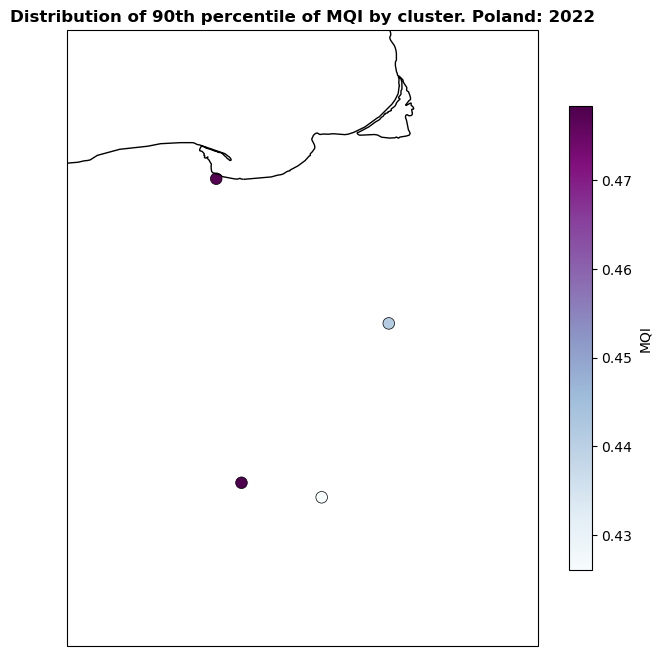

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(resolution='10m')

norm = mcolors.Normalize(vmin=q90_map["MQI"].min(), vmax=q90_map["MQI"].max())
cmap = cm.BuPu

sc = ax.scatter(q90_map['lon'], q90_map['lat'], c=q90_map['MQI'], cmap=cmap, norm=norm, s=70, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(q90_map['lon'].min() - 2, q90_map['lon'].max() + 2)
ax.set_ylim(q90_map['lat'].min() - 2, q90_map['lat'].max() + 2)

ax.set_title(f'Distribution of 90th percentile of MQI by cluster. {region.capitalize()}: {",".join(list(set([str(date_ini_dt.year), str(date_end_dt.year)])))}', 
             fontweight='bold', fontsize=12)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('MQI')

plt.show()